In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import random
import sys
import time
import pyclipper
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import scipy.stats
import plotly.express as px

## Declere The Rectengle

In [2]:
rect = [174, 102, 194, 173, -89]
print(rect)

[174, 102, 194, 173, -89]


# Initial Function

In [3]:
def limit(x, border_min, border_max):
    if x < border_min: return border_min
    elif x > border_max: return border_max
    else: return x


def circ_slice(a, start, length):
    it = itertools.cycle(a)
    next(itertools.islice(it, start, start), None)
    return list(itertools.islice(it, length))

def distance(a, b):
    return np.sqrt(np.sum((np.array(a) - np.array(b))**2))


def area(path):
    path = np.array(path)
    path_shift = np.roll(path, -1, axis=0)
    return 0.5 * np.abs(np.dot(path[:,0], path_shift[:,1]) - \
                        np.dot(path[:,1], path_shift[:,0]))


def draw_solution(polygon, rectangle, intersection=None, show_text=False):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    poly = np.array(polygon)
    ax.fill(poly[:,0], poly[:,1], c='orange', lw=2)
    
    if intersection != None:
        instn = patches.Polygon(intersection, facecolor='black')
        ax.add_patch(instn)
    
    rect = np.array(rectangle)
    ax.fill(rect[:,0], rect[:,1], c='gray', alpha=0.5, lw=2)
    
    if show_text:
        for X in rect:
            ax.text(X[0], X[1], '({}, {})'.format(X[0], X[1]))

    (xmin, xmax), (ymin, ymax) = get_borders(polygon)
    ax.set_xlim(xmin=0.0, xmax=xmax)
    ax.set_ylim(ymin=0.0, ymax=ymax)
    return fig


# Collect bounding box bounds around the parcel
def get_borders(polygon):
    columns = [np.array(polygon)[:,i] for i in range(np.shape(polygon)[1])]
    mins = [np.min(column) for column in columns]
    maxs = [np.max(column) for column in columns]
    return list(zip(mins, maxs))

# Transformation of a problem solution into a rectangle for clipping
# Return the rectangle (A(x1,y1), B(x2,y2), C(x3,y3), D(x4,y4))
def pos2rect(pos, do_round=True):
    # point A
    # point O: rectangle center
    # angle ∠AOD
    xa, ya = pos[0], pos[1]
    xo, yo = pos[2], pos[3]
    angle = pos[4]

    # point D: rotating vector OA on alpha
    # point C: symmetrical to A in relation to O
    # point B: symmetrical to D in relation to O
    
    alpha = pi * angle / 180 # angle in radians
    xd = cos(alpha) * (xa - xo) - sin(alpha) * (ya - yo) + xo
    yd = sin(alpha) * (xa - xo) + cos(alpha) * (ya - yo) + yo
    
    xc = 2 * xo - xa
    yc = 2 * yo - ya
    xb = 2 * xo - xd
    yb = 2 * yo - yd
    
    if do_round:
    # round for clipping
        return [(round(xa), round(ya)),
                (round(xb), round(yb)),
                (round(xc), round(yc)),
                (round(xd), round(yd))]
    else:
        return [(xa, ya), (xb, yb), (xc, yc), (xd, yd)]

def get_intersection(polygon, other):
    pc = pyclipper.Pyclipper()
    pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
    pc.AddPath(other, pyclipper.PT_CLIP, True)
    return pc.Execute(pyclipper.CT_INTERSECTION, 
                      pyclipper.PFT_EVENODD, 
                      pyclipper.PFT_EVENODD)


def in_polygon(rect, polygon):
    try:
        clip = get_intersection(polygon, rect)
        return (clip != []) and \
               (len(clip[0]) == len(rect)) and \
               all(list(map(lambda e: list(e) in clip[0], rect)))
    except pyclipper.ClipperException:
        # sys.exit(0)
        return False


# For further reading
# https://en.wikipedia.org/wiki/N-sphere
def gen_rand_point_in_circle(point, radius):
    R = random.uniform(radius / 2, radius)
    x = point[0] + R * np.cos(random.uniform(0, 2 * pi))
    y = point[1] + R * np.sin(random.uniform(0, 2 * pi))
    return (x, y)

# Simulated annealing Functions

In [4]:
class simulated_annealing_solver(object):
    def __init__(self, polygon,
                 p_radius_1, p_radius_2, p_delta,
                 init_temp=1e+6, decay=0.98,
                 out_iter=1000, in_iter=10):
        self.polygon = polygon
        (self.xmin, self.xmax), (self.ymin, self.ymax) = get_borders(self.polygon)
        self.TEMPERATURE = init_temp
        self.DECAY = decay
        self.p_radius_1 = p_radius_1
        self.p_radius_2 = p_radius_2
        self.p_delta = p_delta
        self.OUTTER_ITERATIONS = out_iter
        self.INNER_ITERATIONS = in_iter
        self.history_route = []
        self.history_cost = []
        self.solution = self.gen_feasible_pos()
    
    def gen_feasible_pos(self):
        while True:
            xo = random.uniform(self.xmin, self.xmax)
            yo = random.uniform(self.ymin, self.ymax)

            xa = xo + pow(-1, random.randint(0, 1)) * \
                          random.uniform(10, min(xo - self.xmin, self.xmax - xo))
            ya = yo + pow(-1, random.randint(0, 1)) * \
                          random.uniform(10, min(yo - self.ymin, self.ymax - yo))
            angle = random.uniform(0.01, 89.99)
            pos = [xa, ya, xo, yo, angle]
            rect = pos2rect(pos)

            if in_polygon(rect, self.polygon): break
        return np.array(pos)
    
    def new_candidate(self):
        t0 = time.time()
        xo, yo = self.solution[0], self.solution[1]
        xa, ya = self.solution[2], self.solution[3]
        angle = self.solution[4]
        while True:
            angle = random.uniform(angle - self.p_delta,
                                   angle + self.p_delta)
            pos = [*gen_rand_point_in_circle([xa, ya], self.p_radius_1),
                   *gen_rand_point_in_circle([xo, yo], self.p_radius_2),
                   angle]
            
            angle = random.uniform(0, p_delta)
            xo_temp, yo_temp = gen_rand_point_in_circle([xo, yo], self.p_radius_1)
            # xo_temp = random.uniform(xo - p_radius_1, xo + self.p_radius_1)
            # yo_temp = random.uniform(yo - p_radius_1, yo + self.p_radius_1)
            xa_temp = xo_temp + random.sample([-1, 1], 1)[0] * random.uniform(self.p_radius_2, min(abs(self.xmin - xo), abs(self.xmax - xo)))
            ya_temp = yo_temp + random.sample([-1, 1], 1)[0] * random.uniform(self.p_radius_2, min(abs(self.ymin - yo), abs(self.ymax - yo)))
            pos = [xo_temp, yo_temp, xa_temp, ya_temp, angle]
            if time.time() - t0 > 0.1: pos = self.gen_feasible_pos()
            if in_polygon(pos2rect(pos), self.polygon): break
        return np.array(pos)
    
    def solve(self):
        self.t0 = time.time()
        for outter in range(self.OUTTER_ITERATIONS):
            for inner in range(self.INNER_ITERATIONS):
                # candidate = self.gen_feasible_pos()
                candidate = self.new_candidate()
                area_candidate = area(pos2rect(candidate, do_round=False))
                area_solution = area(pos2rect(self.solution, do_round=False))
                
                DELTA = area_candidate - area_solution
                if DELTA > 0:
                    self.solution = candidate
                    area_solution = area_candidate
                elif exp(DELTA / self.TEMPERATURE) > random.uniform(0, 1):
                    self.solution = self.gen_feasible_pos()
                    area_solution = area(pos2rect(self.solution, do_round=False))
                
            sys.stdout.write('\r')
            sys.stdout.write("# Iteration {}".format(outter))
            sys.stdout.flush()
            self.history_route.append(self.solution)
            self.history_cost.append(area_solution)

            self.TEMPERATURE *= self.DECAY
        self.t1 = time.time()
        return self.solution
        
    def print(self):
        if self.solution == None:
            print('run solve method first')
            return
        print('Running time: {}'.format(self.t1-self.t0))
        print(self.history_cost[-1])
        print(self.solution)
        
    def get_history(self):
        return (self.history_cost, self.history_route)

# Particle Swarm Optimization (PSO)

In [5]:
class PSO(object):
    def __init__(self, polygon, dimensions=4, 
                 num_particles=20, num_iterations=4000, 
                 psi=0.7, acceleration=(1.47, 1.47)):
        self.polygon = polygon
        (self.xmin, self.xmax), (self.ymin, self.ymax) = get_borders(self.polygon)
        self.DIM = dimensions
        self.NUM_PTS = num_particles
        self.NUM_ITER = num_iterations
        self.swarm = self.init_swarm()
        self.psi = psi
        self.a_1, self.a_2 = acceleration
        
        self.history_iterations = []
        self.history_values = []


    def gen_feasible_pos(self):
        while True:
            xo = random.uniform(self.xmin, self.xmax)
            yo = random.uniform(self.ymin, self.ymax)

            xa = xo + pow(-1, random.randint(0, 1)) * \
                          random.uniform(10, min(xo - self.xmin, self.xmax - xo))
            ya = yo + pow(-1, random.randint(0, 1)) * \
                          random.uniform(10, min(yo - self.ymin, self.ymax - yo))
            angle = random.uniform(0.01, 89.99)
            pos = [xa, ya, xo, yo, angle]
            rect = pos2rect(pos)

            if in_polygon(rect, self.polygon): break
        return np.array(pos)

    def init_particle(self, bests=None):
        x = self.gen_feasible_pos()
        f_x = area(pos2rect(x))
        if bests == None:
            return {'v': np.zeros(self.DIM),
                    'x': x,
                    'f_x': f_x,
                    'best_x': x,
                    'best_f_x': f_x,
                    'best_x_for_swarm': []}
        else:
            return {'v': np.zeros(self.DIM),
                    'x': x,
                    'f_x': f_x,
                    'best_x': bests[0],
                    'best_f_x': bests[1],
                    'best_x_for_swarm': bests[2]}


    def init_swarm(self):
        return [self.init_particle() for i in range(self.NUM_PTS)]


    def best_particle(self, p1, p2):
        return p1 if p1['f_x'] > p2['f_x'] else p2


    def get_best_particle(self, swarm):
        return reduce(lambda acc, x: self.best_particle(acc, x), swarm)
    
    
    def update(self, best_particle):
        for particle in self.swarm:
            if particle['f_x'] > particle['best_f_x']:
                particle['best_x'] = particle['x'].copy()
                particle['best_f_x'] = particle['f_x']
            particle['best_x_for_swarm'] = best_particle['best_x']
    
    def local_update(self, num_nb):
        for idx, particle in enumerate(self.swarm):
            start_idx = (idx - num_nb) % self.NUM_PTS
            nbhood = circ_slice(self.swarm, start_idx, num_nb)
            best_nb = self.best_particle(nbhood)

            if particle['f_x'] > particle['best_f_x']:
                particle['best_x'] = particle['x'].copy()
                particle['best_f_x'] = particle['f_x']
            particle['best_x_for_swarm'] = best_nb['best_x']
    
    def move(self, particle):
        nv = dict(particle)
        v = np.zeros(self.DIM)
        x = np.zeros(self.DIM)
        
        for i in range(self.DIM):
            v[i] = self.psi * particle['v'][i] + \
                   self.a_1 * random.uniform(0, 1) * (particle['best_x'][i] - particle['x'][i]) + \
                   self.a_2 * random.uniform(0, 1) * (particle['best_x_for_swarm'][i] - particle['x'][i])
            x[i] = round(particle['x'][i] + v[i])
        
        if not in_polygon(pos2rect(x), self.polygon):
            x = particle['x']
#             if random.uniform(0, 1) > 0.1:
#                 x = self.gen_feasible_pos()
#             else:
#                 x = particle['x']
            
        nv['v'] = v
        nv['x'] = x
        nv['f_x'] = area(pos2rect(x))
        return nv
    
    def solve(self):
        v_move = np.vectorize(self.move)
        
        self.t0 = time.time()
        self.solution = self.get_best_particle(self.swarm)
        for i in range(self.NUM_ITER):
            self.update(self.solution)
            self.swarm = v_move(self.swarm)
            candidate = self.get_best_particle(self.swarm)
            if (candidate['best_f_x'] > self.solution['best_f_x']):
                self.solution = candidate

            if i % 10 == 0:
                self.history_iterations.append(i)
                self.history_values.append(self.solution['best_f_x'])
        self.t1 = time.time()
        
        return self.solution
    
    def solve_with_nb(self, num_nb=3):
        if num_nb + 1 > self.NUM_PTS:
            self.solve()
            return
        
        v_move = np.vectorize(self.move)
        
        self.t0 = time.time()
        for i in range(self.NUM_ITER):
            self.local_update(num_nb)
            self.swarm = v_move(self.swarm)

            if i % 10 == 0:
                self.history_iterations.append(i)
                self.history_values.append(self.swarm[0]['best_f_x'])
        self.t1 = time.time()
        
        self.solution = self.get_best_particle(self.swarm)
        
    def print(self):
        if self.solution == None:
            print('run solve method first')
            return
        print('Running time: {}'.format(self.t1 - self.t0))
        print('x:', self.solution['x'])
        print('f(x):', self.solution['f_x'], '\n') #self.history_values[-1]
        print(self.solution)
    
    def draw_logs(self):
        fig, ax = plt.subplots(figsize=(10,6))
        ax.semilogy(self.history_iterations, self.history_values)
        ax.set_title('Evolution of the best distance')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Distance')
        return fig
    
    def get_history(self):
        return (self.history_iterations, self.history_values)
    
    def get_solution(self):
        return self.solution

In [6]:
rect_path = pos2rect(rect)
print(rect_path)
pa, pb, pc, pd = np.array(rect_path)

print(area(rect_path))

[(174, 102), (265, 154), (214, 244), (123, 192)]
10842.0


# Polygons Declaration [0,1, 2 , 3]

In [7]:
polygons = [[(10,10),(10,400),(400,400),(400,10)],
            [(10,10),(10,300),(250,300),(350,130),(200,10)],
            [(50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200)],
            [(50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50)]]
areas = list(map(area, polygons))

areas

[152100.0, 81100.0, 52500.0, 116650.0]

# Optimization  the algorithm "Particle Swarm Optimization (PSO)"

In [8]:
polygon = polygons[1]

dimensions = 5
num_particles = 20
num_iterations = 5000
psi = 0.3
acceleration = (1, 2)

pso = PSO(polygon, dimensions=dimensions, 
          num_particles=num_particles, num_iterations=num_iterations, 
          psi=psi, acceleration=acceleration)

solution = pso.solve()
print('Coverage:', solution['f_x'] / area(polygon))

Coverage: 0.636498150431566


### For plotiing the polygone and rectengle

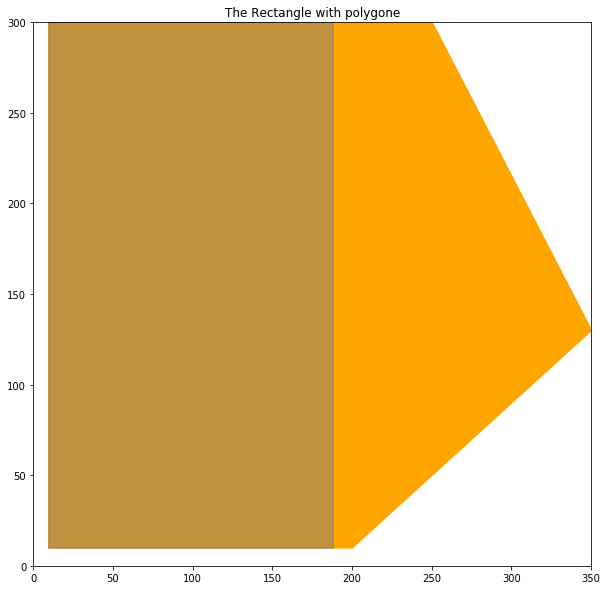

In [9]:
draw_solution(polygon, pos2rect(solution['x']))
plt.title('The Rectangle with polygone')
plt.draw()
plt.pause(0.01)



### Print the Particle Swarm Optimization (PSO)

In [10]:
print(solution)

print('\nCoverage:', solution['f_x']/ area(polygon))

print('Area:', solution['f_x'])

{'v': array([-1.74799098e+000,  3.55005011e-002, -7.62593365e-002,
       -1.89211337e-288,  7.38956241e-256]), 'x': array([188., 300.,  99., 155.,  63.]), 'f_x': 51620.0, 'best_x': array([188., 300.,  99., 155.,  63.]), 'best_f_x': 51620.0, 'best_x_for_swarm': array([188., 300.,  99., 155.,  63.])}

Coverage: 0.636498150431566
Area: 51620.0


# Optimization  the algorithm "Simulated Annealing"

In [11]:
polygon = polygons[1]

init_temp = areas[0] / 2
in_iter = 100
out_iter = 1000
decay = .98

# Parameters for radius neighbourhood
# p_radius_1 = 50
# p_radius_2 = 100
# p_delta = 15

# Parameters for Can implementation
p_radius_1 = 30
p_radius_2 = 20
p_delta = 89.99

sao = simulated_annealing_solver(polygon,
                                 p_radius_1, p_radius_2, p_delta,
                                 init_temp=init_temp, decay=decay,
                                 out_iter=out_iter, in_iter=in_iter)

solution = sao.solve()
print(' Coverage:', area(pos2rect(solution)) / area(polygon))


# Iteration 999 Coverage: 0.4434155363748459


###  For Plotting the Polygone and rectengle

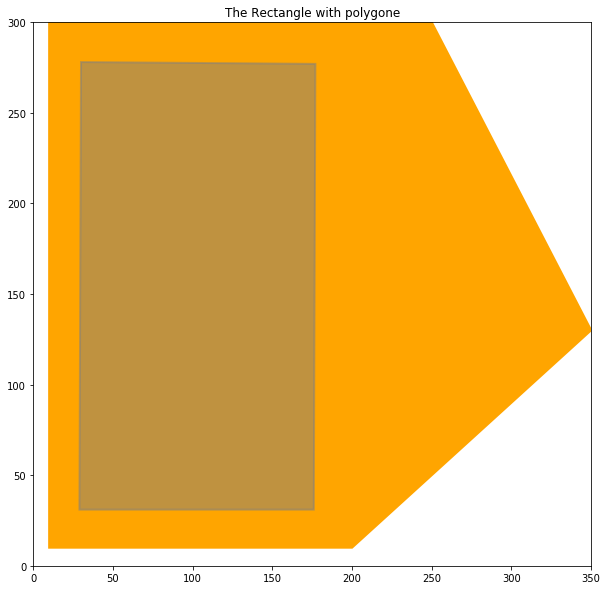

In [26]:
draw_solution(polygon, pos2rect((solution)))
plt.title('The Rectangle with polygone')
plt.draw()
plt.pause(0.01)

In [28]:
print(solution)

print('\nCoverage:', area(pos2rect(solution)) / area(polygon))
print('Area:', area(pos2rect(solution)))

[176.97935255 277.40738881 103.0416247  154.35142537  61.64620317]

Coverage: 0.44680641183723796
Area: 36236.0


# sample of 30 results by PSO

In [32]:
pso_solutions_list = []
for i in range(30):
    polygon = polygons[3]

    dimensions = 5
    num_particles = 20
    num_iterations = 5000
    psi = 0.2
    acceleration = (1, 2)

    pso = PSO(polygon, dimensions=dimensions, 
              num_particles=num_particles, num_iterations=num_iterations, 
              psi=psi, acceleration=acceleration)

    solution = pso.solve()
    print('Coverage:', solution['f_x'] / area(polygon))

#     draw_solution(polygon, pos2rect(solution['x'])) # Uncomment this to see plots
    pso_solutions_list.append(solution['f_x'] / area(polygon))


Coverage: 0.4176596656665238
Coverage: 0.32012001714530647
Coverage: 0.3357736819545649
Coverage: 0.3793570510072868
Coverage: 0.37668238319759967
Coverage: 0.33688812687526787
Coverage: 0.3753107586798114
Coverage: 0.43093013287612514
Coverage: 0.4026403771967424
Coverage: 0.39434204886412344
Coverage: 0.27257608229747105
Coverage: 0.3600514359194171
Coverage: 0.4386626660951565
Coverage: 0.3458894127732533
Coverage: 0.15225032147449635
Coverage: 0.23118731247321045
Coverage: 0.408058294042006
Coverage: 0.3575825117873982
Coverage: 0.3753107586798114
Coverage: 0.42234033433347623
Coverage: 0.39297042434633517
Coverage: 0.3354479211315902
Coverage: 0.3730818688384055
Coverage: 0.3600514359194171
Coverage: 0.36821260180025717
Coverage: 0.38796399485640803
Coverage: 0.24891555936562365
Coverage: 0.3971881697385341
Coverage: 0.30532361765966565
Coverage: 0.24277753964852122


In [34]:
print(pso_solutions_list)

[0.4176596656665238, 0.32012001714530647, 0.3357736819545649, 0.3793570510072868, 0.37668238319759967, 0.33688812687526787, 0.3753107586798114, 0.43093013287612514, 0.4026403771967424, 0.39434204886412344, 0.27257608229747105, 0.3600514359194171, 0.4386626660951565, 0.3458894127732533, 0.15225032147449635, 0.23118731247321045, 0.408058294042006, 0.3575825117873982, 0.3753107586798114, 0.42234033433347623, 0.39297042434633517, 0.3354479211315902, 0.3730818688384055, 0.3600514359194171, 0.36821260180025717, 0.38796399485640803, 0.24891555936562365, 0.3971881697385341, 0.30532361765966565, 0.24277753964852122]


# sample of 30 results by Simulated Annealing

In [29]:
polygon = polygons[3]

sao_solutions_list = []
for i in range(30):
    init_temp = areas[0] / 2
    in_iter = 100
    out_iter = 1000
    decay = 0.98

    # Parameters for radius neighbourhood
    # p_radius_1 = 50
    # p_radius_2 = 100
    # p_delta = 15

    # Parameters for Can implementation
    p_radius_1 = 30
    p_radius_2 = 20
    p_delta = 89.99

    sao = simulated_annealing_solver(polygon,
                                     p_radius_1, p_radius_2, p_delta,
                                     init_temp=init_temp, decay=decay,
                                     out_iter=out_iter, in_iter=in_iter)

    solution = sao.solve()
    print('Coverage:', area(pos2rect(solution)) / area(polygon))
    # draw_solution(polygon, pos2rect((solution))) # Uncomment this to see plots
    sao_solutions_list.append(area(pos2rect(solution)) / area(polygon))


# Iteration 999Coverage: 0.18383197599657095
# Iteration 999Coverage: 0.08617659665666524
# Iteration 999Coverage: 0.2180282897556794
# Iteration 999Coverage: 0.14204029147021002
# Iteration 999Coverage: 0.16130304329189885
# Iteration 999Coverage: 0.25122160308615515
# Iteration 999Coverage: 0.2222717531075868
# Iteration 999Coverage: 0.2744706386626661
# Iteration 999Coverage: 0.19090870124303472
# Iteration 999Coverage: 0.18434633519074153
# Iteration 999Coverage: 0.18995285040720103
# Iteration 999Coverage: 0.26436776682383195
# Iteration 999Coverage: 0.20778396913844835
# Iteration 999Coverage: 0.19970852978997
# Iteration 999Coverage: 0.1847321045863695
# Iteration 999Coverage: 0.1757179597085298
# Iteration 999Coverage: 0.20920702957565365
# Iteration 999Coverage: 0.22100728675525075
# Iteration 999Coverage: 0.21894556365195028
# Iteration 999Coverage: 0.1620488641234462
# Iteration 999Coverage: 0.11287612516073725
# Iteration 999Coverage: 0.16807543934847835
# Iteration 999Cove

In [41]:
print(sao_solutions_list)

[0.18383197599657095, 0.08617659665666524, 0.2180282897556794, 0.14204029147021002, 0.16130304329189885, 0.25122160308615515, 0.2222717531075868, 0.2744706386626661, 0.19090870124303472, 0.18434633519074153, 0.18995285040720103, 0.26436776682383195, 0.20778396913844835, 0.19970852978997, 0.1847321045863695, 0.1757179597085298, 0.20920702957565365, 0.22100728675525075, 0.21894556365195028, 0.1620488641234462, 0.11287612516073725, 0.16807543934847835, 0.2157136733819117, 0.2521131590227175, 0.1894470638662666, 0.15329189884269181, 0.25004714959279895, 0.17512216030861552, 0.13733390484354907, 0.11560222888984141]


# Tuckey boxes corresponding to the results on the same chart

### Simlated Anneling 

In [43]:
import plotly.express as px
import pandas as pd

data = sao_solutions_list
df = pd.DataFrame(dict(
    linear=data,
    inclusive=data,
    exclusive=data
)).melt(var_name="quartilemethod")


fig = px.box(df, y="value", facet_col="quartilemethod", color="quartilemethod",
             boxmode="overlay", points='all')

fig.update_traces(quartilemethod="linear", jitter=0, col=1)
fig.update_traces(quartilemethod="inclusive", jitter=0, col=2)
fig.update_traces(quartilemethod="exclusive", jitter=0, col=3)

fig.show()


### Particle Swarm Optimization (PSO)

In [44]:
import plotly.express as px
import pandas as pd

data = pso_solutions_list
df = pd.DataFrame(dict(
    linear=data,
    inclusive=data,
    exclusive=data
)).melt(var_name="quartilemethod")


fig = px.box(df, y="value", facet_col="quartilemethod", color="quartilemethod",
             boxmode="overlay", points='all')

fig.update_traces(quartilemethod="linear", jitter=0, col=1)
fig.update_traces(quartilemethod="inclusive", jitter=0, col=2)
fig.update_traces(quartilemethod="exclusive", jitter=0, col=3)

fig.show()


# Two Sample T-test

In [36]:
import scipy.stats
t_test = scipy.stats.ttest_ind(sao_solutions_list, pso_solutions_list, axis=0, equal_var=False, nan_policy='propagate')

In [37]:
t_test

Ttest_indResult(statistic=-10.99422715469237, pvalue=4.0009621745915356e-15)

In [38]:
sum(pso_solutions_list)/30

0.35151821688812684